In [11]:
# import time
# time.sleep(60*10) # Sleep for 3 seconds

In [12]:
show_plots = True

In [13]:
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
import numpy as np
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
from datetime import datetime
import math


In [14]:
# Load the model with LoS tables from the last exercise
input_path = './../../input/'
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'los_tables')

In [15]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:", broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


## Add demographic information

In [59]:
age = pd.read_excel(input_path + 'zone_stats/sbb_plr_alter5Jahre.xlsx')
age_sex = pd.read_excel(input_path + 'zone_stats/sbb_plr_alter5Jahre_geschlecht.xlsx', header=[0,1])

age_gender_groups = {'age_groups': list(age.columns[1:])}
genders = [x[1] for x in age_sex.columns[1:]][:2]
age_sex.head()

Alter in 5-Jahresschritten  unter 5          5 bis unter 10           \
                   Geschlecht männlich weiblich       männlich weiblich   
0                      Berlin    95363    90512          89065    84377   
1       01011101 Stülerstraße       66       66             52       46   
2  01011102 Großer Tiergarten        3        3              -        -   
3       01011103 Lützowstraße      116      120             90       81   
4       01011104 Körnerstraße      105      108            115      112   

  10 bis unter 15          15 bis unter 20          20 bis unter 25  ...  \
         männlich weiblich        männlich weiblich        männlich  ...   
0           82438    77651           76586    72290          101079  ...   
1              42       27              23       39             121  ...   
2               3        3               4        -               9  ...   
3              82       81              91       78             187  ...   
4             109      117             117      110             241  ...   

  75 bis unter 80          80 bis unter 85          85 bis unter 90           \
         männlich weiblich        männlich weiblich        männlich weiblich   
0           69733    87619           54837    78363           23273    39212   
1              92       89              68       73              22       29   
2               6        -               3        6               -        -   
3              84       82              55       91              16       47   
4              35       21              12       18               9        9   

  90 bis unter 95          95 und mehr           
         männlich weiblich    männlich weiblich  
0            7294    17164        1320     5754  
1               6       12           6        -  
2               -        -           -        -  
3              12       18           -       24  
4               3        9           -        3  

[5 rows x 41 columns]

In [62]:
anzahl_wege_alter15 = pd.read_excel(input_path + 'transport_stats/anzahl_wege_alter15.xlsx')
anzahl_wege_alter15['age_groups'] = [[] for x in range(len(anzahl_wege_alter15))]
anzahl_wege_alter15['age_groups'].iloc[0] = age_groups[0:3]
anzahl_wege_alter15['age_groups'].iloc[1] = age_groups[3:5]
anzahl_wege_alter15['age_groups'].iloc[2] = age_groups[5:9]
anzahl_wege_alter15['age_groups'].iloc[3] = age_groups[9:13]
anzahl_wege_alter15['age_groups'].iloc[4] = age_groups[13:]
anzahl_wege_alter15[0:5]

,Altersgruppe,Männlich,Ungew. Fallzahl,Weiblich,Ungew. Fallzahl.1,Alle,Ungew.Fallzahl,Mobilität in Städten – SrV 2018,age_groups
0,0 bis unter 15 Jahre,3.0,3.321,3.0,3.448,3.0,6.769,Berlin,"[unter 5, 5 bis unter 10, 10 bis unter 15]"
1,15 bis unter 25 Jahre,3.2,1.328,3.3,1.330,3.2,2.658,Tab 6.1,"[15 bis unter 20, 20 bis unter 25]"
2,25 bis unter 45 Jahre,3.7,4.577,3.9,5.219,3.8,9.796,Wochentag: Mittlerer Werktag,"[25 bis unter 30, 30 bis unter 35, 35 bis unte..."
3,45 bis unter 65 Jahre,3.5,4.973,3.6,5.390,3.6,10.363,Berechnet am: 15.11.2019,"[45 bis unter 50, 50 bis unter 55, 55 bis unte..."
4,65 Jahre und älter,3.3,4.175,3.2,4.346,3.3,8.521,Zeitraum: Gesamtes Jahr,"[65 bis unter 70, 70 bis unter 75, 75 bis unte..."


In [61]:
age_gender_groups['trips_number']: {
    ['männlich']: 
}

Alter in 5-Jahresschritten  unter 5          5 bis unter 10  \
                              Geschlecht männlich weiblich       männlich   
0                                 Berlin    95363    90512          89065   
1                  01011101 Stülerstraße       66       66             52   
2             01011102 Großer Tiergarten        3        3              -   
3                  01011103 Lützowstraße      116      120             90   
4                  01011104 Körnerstraße      105      108            115   
..                                   ...      ...      ...            ...   
444            12302110 Dannenwalder Weg      349      302            418   
445             12302211 Lübarser Straße       64       58             53   
446           12302212 Rollbergesiedlung      240      195            224   
447                 12304313 Borsigwalde      165      145            136   
448  12304314 Ziekowstraße/Freie Scholle      168      175            180   

             10 bis unter 15          15 bis unter 20           \
    weiblich        männlich weiblich        männlich weiblich   
0      84377           82438    77651           76586    72290   
1         46              42       27              23       39   
2          -               3        3               4        -   
3         81              82       81              91       78   
4        112             109      117             117      110   
..       ...             ...      ...             ...      ...   
444      402             413      414             398      368   
445       39              45       48              66       41   
446      213             214      205             207      178   
447      104             115      107             101      106   
448      161             176      155             181      164   

    20 bis unter 25  ... 75 bis unter 80          80 bis unter 85           \
           männlich  ...        männlich weiblich        männlich weiblich   
0            101079  ...           69733    87619           54837    78363   
1               121  ...              92       89              68       73   
2                 9  ...               6        -               3        6   
3               187  ...              84       82              55       91   
4               241  ...              35       21              12       18   
..              ...  ...             ...      ...             ...      ...   
444             391  ...             188      239             120      223   
445             100  ...             128      152              88      128   
446             169  ...             119      141              86      110   
447             199  ...             149      194              90      148   
448             206  ...             283      411             197      291   

    85 bis unter 90          90 bis unter 95          95 und mehr           
           männlich weiblich        männlich weiblich    männlich weiblich  
0             23273    39212            7294    17164        1320     5754  
1                22       29               6       12           6        -  
2                 -        -               -        -           -        -  
3                16       47              12       18           -       24  
4                 9        9               3        9           -        3  
..              ...      ...             ...      ...         ...      ...  
444              47       96              19       20           -       18  
445              43       50              15        9           3        7  
446              31       59              15        9           -        6  
447              44       78              18       22           -        -  
448              89      157              27       75           -       26  

[449 rows x 41 columns]

In [ ]:
age_sex[('10 bis unter 20', 'weiblich')]

0      149941
1          66
2           3
3         159
4         227
        ...  
444       782
445        89
446       383
447       213
448       319
Name: (10 bis unter 20, weiblich), Length: 449, dtype: object

## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.



In [ ]:
trip_purposes = ['Ausbildung', 'Begleitung', 'Einkauf', 'Arbeit', 'Erledigung', 'Freizeit']

for trip_purpose in trip_purposes:
    # fetch
    clnmn = 'emission_'+trip_purpose
    [gender for gender in genders]
    sm.zones[clnmn] = [[row[age_group] for age_group in age_groups] for n, row in sm.zones.iterrows()]
    if trip_purpose == "Ausbildung":
        9
    elif trip_purpose == "Ausbildung":
        9
    


In [16]:
# Start with emission and attraction from commuting purposes
# Assumptions (usually derived from a mobility survey):
employment_rate = 0.7
home_office_rate = 0.1
work_trips_per_day = 1.05 # we set up the model for one average weekday!
sm.zones['emission'] = sm.zones['pop'] * work_trips_per_day * (1-home_office_rate) * employment_rate
sm.zones['attraction'] = sm.zones['emp']

# Now add the shopping purpose (usually derived from a mobility survey)
shopping_trips_per_day = 0.3
attraction_per_POI = sm.zones['pop'].mean() / sm.zones['pois'].mean() * shopping_trips_per_day * 1.8202595
sm.zones['emission'] += sm.zones['pop'] * shopping_trips_per_day
sm.zones['attraction'] += sm.zones['pois'] * attraction_per_POI
print('Total emission:', int(sm.zones['emission'].sum()), \
    'Total attraction:', int(sm.zones['attraction'].sum()), \
    'Trips per person:',  round(sm.zones['emission'].sum()/sm.zones['pop'].sum(),4))

Total emission: 3630069 Total attraction: 3628602 Trips per person: 0.9615


Text(0.5, 1.0, 'attraction per zone area')

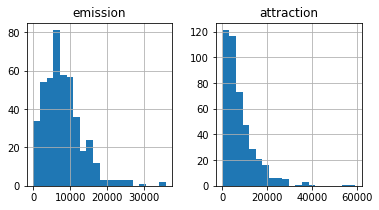

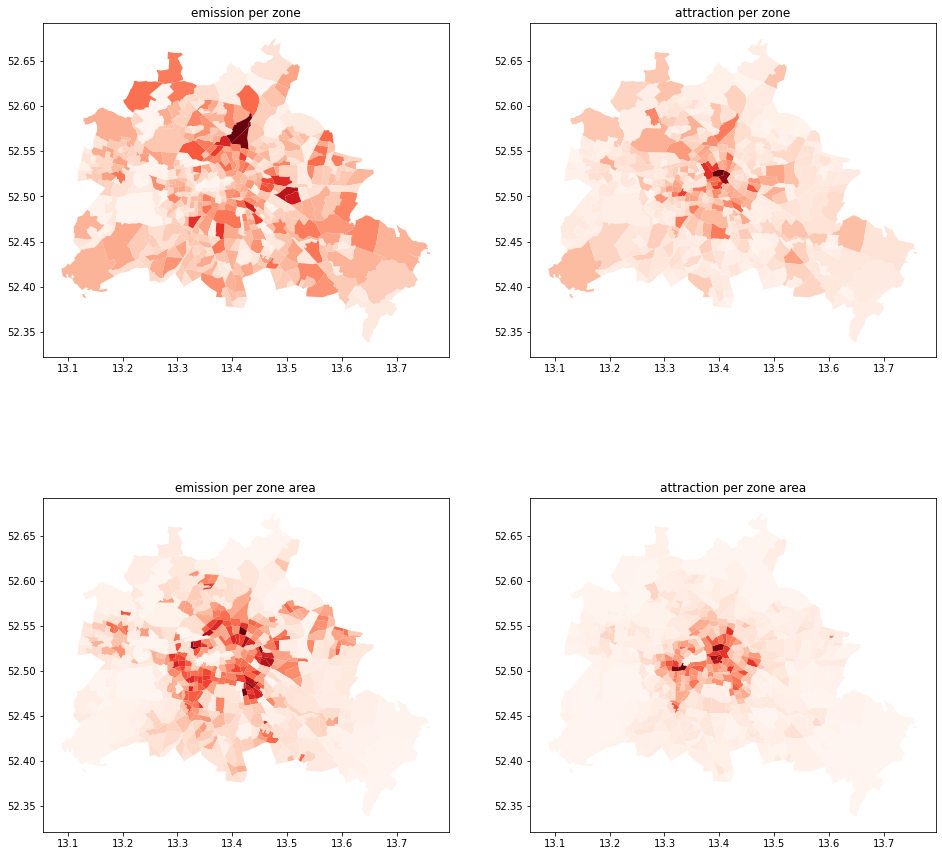

In [17]:
sm.zones[['emission', 'attraction']].hist(bins=20, figsize=(6,3))
fig, ax = plt.subplots(2, 2, figsize=(16,16))
sm.zones.plot(ax=ax.flat[0], column='emission', cmap="Reds")
ax.flat[0].set_title("emission per zone")
sm.zones.plot(ax=ax.flat[1], column='attraction', cmap="Reds")
ax.flat[1].set_title("attraction per zone")
sm.zones.plot(ax=ax.flat[2], cmap="Reds", column=np.array([a/g.area for a,g in zip(sm.zones['emission'].values, sm.zones['geometry'].values) ]))
ax.flat[2].set_title("emission per zone area")
sm.zones.plot(ax=ax.flat[3], cmap="Reds", column=np.array([a/g.area for a,g in zip(sm.zones['attraction'].values, sm.zones['geometry'].values) ]))
ax.flat[3].set_title("attraction per zone area")


In [18]:
car_ownership = .4
bike_possible = .4

car_1_bike_1 = (car_ownership)*(bike_possible)
car_1_bike_0 = (car_ownership)*(1-bike_possible)
car_0_bike_1 = (1-car_ownership)*(bike_possible)
car_0_bike_0 = (1-car_ownership)*(1-bike_possible)


In [19]:
# Now we need to introduce our demand segments.
# Car owners and PT captives is a good start.
# Other common demand segments are trip purposes, income groups, age groups.



sm.segments = ['car_owner', 'pt_captive']
car_ownership = 0.4 # To-Do: replace with demographic data
sm.zones[('car_owner', 'emission')] = sm.zones['emission'] * car_ownership
sm.zones[('pt_captive', 'emission')] = sm.zones['emission'] * (1-car_ownership)
sm.zones[('car_owner', 'attraction')] = sm.zones['attraction'] * car_ownership
sm.zones[('pt_captive', 'attraction')] = sm.zones['attraction'] * (1-car_ownership)

# Cast columns to integer
sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'emission')].astype(int)
sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'attraction')].astype(int)
sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'emission')].astype(int)
sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'attraction')].astype(int)

In [20]:
# Delete the non-segmented columns to prevent errors
del sm.zones['emission']
del sm.zones['attraction']
# sm.zones.sample()

## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

To-Do:
- check for distance travelled per inhabitant (compare to survey data)
- do we have transport data on district level or so?
- plot graphs for OD Matrix
- FRATAR algorithm, do we use it? Do we have to understand it?
- number is too small in relation to trips outside of zone. what has to be done?
- sometimes zones still have an above average connection to another zone even if its on the other side of the city. Whats the reason? What should be done?
- maybe stadtaubahn is treated as too slow in relation to other routes?

In [27]:
sm.zones.columns

Index([                'BEZIRKSNAM',                 'PLANUNGSRA',
                       'DATUM_GUEL',                 'FLAECHENGR',
                       'broker Dow',                        'pop',
                   'popCentroidLat',             'popCentroidLon',
                              'emp',                       'pois',
                   'poiCentroidLat',             'poiCentroidLon',
                          'amenity',                   'building',
                            'craft',                       'shop',
                          'leisure',                    'tourism',
                            'water',                    'college',
                           'school',                 'university',
                     'kindergarten',                     'retail',
                      'marketplace',                     'bakery',
                        'beverages',                    'butcher',
                      'convenience',                'greengroc

In [21]:

# use data on strecke wegzweck to make good impedance matrix
strecke_wegzweck = pd.read_excel(input_path + 'transport_stats/strecke_wegzwecke_mid17_t9.xlsx')
strecke_wegzweck

,Wegzweck,km,Quelle,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Arbeit,12,MiD 2017,NaN,NaN,NaN,NaN,NaN,NaN
1,dienstlich,18,Tabelle 9,NaN,NaN,NaN,NaN,NaN,NaN
2,Ausbildung,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Einkauf,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Erledigung,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Freizeit,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Begleitung,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
sm.car_los.head(1)

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type,price
index,,,,,,,,,,,
0,zone_01011101,zone_01011101,0.0,[zone_01011101],[],[],[],0.0,[car],car,0.0


In [23]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 60*5)
car_imp_matrix.head(2)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    300.000000    515.416152    378.909144    423.158481   
zone_01011102    531.404412    300.000000    610.748270    646.444907   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    346.622563    456.467964    593.923487    575.352988   
zone_01011102    539.222850    649.068251    727.505742    724.671906   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101    655.513599    596.834308  ...   1566.516984   1763.012168   
zone_01011102    848.113886    689.211031  ...   1693.525666   1884.182430   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   1352.782580   1718.789457   1710.408296   1514.622193   
zone_01011102   1479.791262   1845.798139   1821.971975   1641.630875   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   1482.843711   1561.147286   1300.467720   1409.144919  
zone_01011102   1609.852393   1688.155968   1447.505696   1556.182895  

[2 rows x 448 columns]

In [24]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

pt_imp_matrix = pt_imp_matrix.replace(0, 60*5)
pt_imp_matrix.head(2)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    300.000000    792.010207    734.167399   1156.649404   
zone_01011102    792.010207    300.000000    878.907216    946.660118   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    869.899147   1264.712248   1307.039594   1473.676377   
zone_01011102    659.909860   1253.671977   1071.838838   1243.094710   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101   1234.940027   1490.902531  ...   2845.101360   3208.905563   
zone_01011102   1356.536329   1255.701775  ...   2916.531973   3352.836176   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   2552.026762   2806.032238   2622.905930   2449.464342   
zone_01011102   2695.957376   2949.962852   2766.836543   2593.394955   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   2583.616679   2779.468180   2354.976057   3036.319747  
zone_01011102   2727.547292   2923.398793   2480.406670   3161.750360  

[2 rows x 448 columns]

In [25]:
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
deterrence_matrix=  {'car_owner': car_imp_matrix,
                    'pt_captive': pt_imp_matrix}
distr_params = {'od_volume_from_zones_kwargs': {'power': {'car_owner':1.2, 'pt_captive':1.2}, 'intrazonal':True}}

sm.step_distribution(segmented=True, deterrence_matrix=deterrence_matrix, **distr_params)

sm.volumes.head(3)

# 	origin	destination	car_owner	pt_captive	all
# 0	zone_01011101	zone_01011101	1.284043	0.913413	2.197456
# 1	zone_01011101	zone_01011102	0.994564	1.253673	2.248237
# 2	zone_01011101	zone_01011103	2.662875	3.587748	6.25062

car_owner
pt_captive


,origin,destination,car_owner,pt_captive,all
0,zone_01011101,zone_01011101,1.284043,0.913413,2.197456
1,zone_01011101,zone_01011102,0.994564,1.253673,2.248237
2,zone_01011101,zone_01011103,2.662875,3.587748,6.250623


In [26]:
min([(car_imp_matrix*-1/100000).iloc[n].min() for n in range(len(car_imp_matrix))]), max([(car_imp_matrix*-1/100000).iloc[n].max() for n in range(len(car_imp_matrix))])

(-0.051660846886635, -0.0014631854498390001)

Text(0.5, 0, 'Travel time between zones rescaled (*-1/8000)')

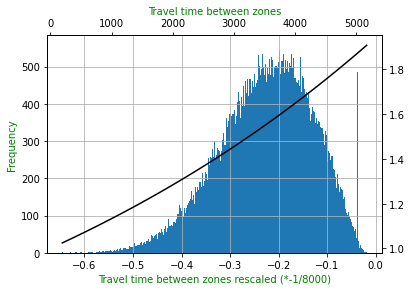

In [46]:
mult = 1/8000
fric_vals = pd.DataFrame({'0': np.asarray([item for sublist in [list((car_imp_matrix*-mult).iloc[n]) for n in range(len(car_imp_matrix))] for item in sublist])})
ax = fric_vals.hist(bins=1000)
ax1 = ax.flat[0]
ax2 = ax1.twinx().twiny()

xs = [x+fric_vals.min()[0] for x in np.array(range(100))*((fric_vals.max()-fric_vals.min())/100)[0]]
ys = [math.e**-x for x in xs]
xs_recoded = [x/-mult for x in xs]#[::-1]

ax2.plot(xs_recoded, ys, 'k')
# ax2.set_title('X')
ax1.set_title('')

ax2.set_ylabel('Deterrence parameter', color='b')
ax1.set_ylabel('Frequency', color='g')
ax2.set_xlabel('Travel time between zones', color='g')
ax1.set_xlabel('Travel time between zones rescaled (*-1/8000)', color='g')


In [47]:
car_imp_matrix_inv = math.e**(car_imp_matrix*-1/100000)
pt_imp_matrix_inv = math.e**(pt_imp_matrix*-1/100000)
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
deterrence_matrix=  {'car_owner': car_imp_matrix_inv,
                    'pt_captive': pt_imp_matrix_inv}
distr_params= {'od_volume_from_zones_kwargs': {'power': {'car_owner':3, 'pt_captive':3}, 'intrazonal':True}}

sm.step_distribution(segmented=True, deterrence_matrix=deterrence_matrix, **distr_params)

sm.volumes.head(3)

# 	origin	destination	car_owner	pt_captive	all
# 0	zone_01011101	zone_01011101	3.687372	6.403295	10.090667
# 1	zone_01011101	zone_01011102	1.926702	3.187872	5.114574
# 2	zone_01011101	zone_01011103	6.148845	10.322432	16.47127

car_owner HIii
pt_captive HIii


,origin,destination,car_owner,pt_captive,all
0,zone_01011101,zone_01011101,3.687372,5.586500,9.273871
1,zone_01011101,zone_01011102,1.926702,2.905023,4.831724
2,zone_01011101,zone_01011103,6.148845,9.289756,15.438601


array([[<AxesSubplot:title={'center':'car_owner'}>,
        <AxesSubplot:title={'center':'pt_captive'}>],
       [<AxesSubplot:title={'center':'all'}>, <AxesSubplot:>]],
      dtype=object)

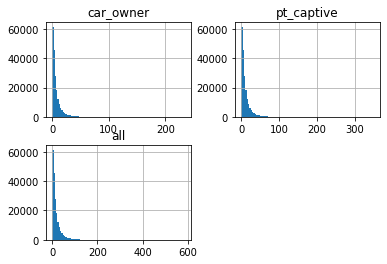

In [48]:
sm.volumes.hist(bins=100)

array([[<AxesSubplot:title={'center':'car_owner'}>,
        <AxesSubplot:title={'center':'pt_captive'}>],
       [<AxesSubplot:title={'center':'all'}>, <AxesSubplot:>]],
      dtype=object)

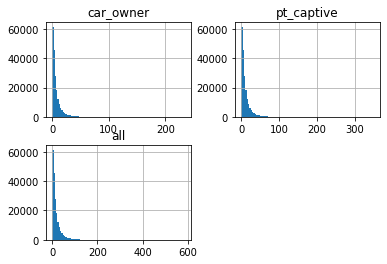

In [49]:
sm.volumes.hist(bins=100)

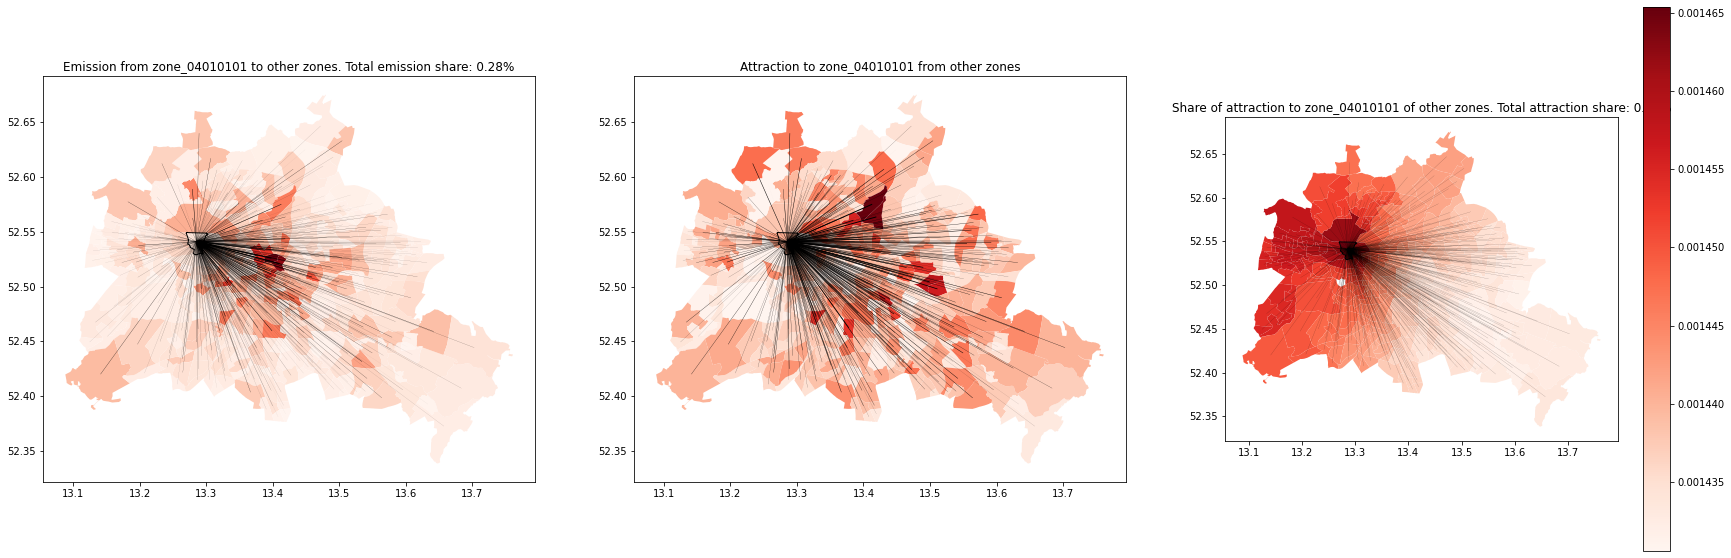

In [50]:
if show_plots:
    N = 1
    fig, ax = plt.subplots(nrows=N, ncols=3, figsize=(30,10*N))
    for (n, ind) in enumerate(np.random.permutation(len(sm.zones))[:N]):
        z_id = sm.zones.index[ind]
        
        z_emission = sm.volumes[['destination', 'all']][sm.volumes['origin']==z_id]
        z_attraction = sm.volumes[['origin', 'all']][sm.volumes['destination']==z_id]
        z_emission_from = np.array([item for sublist in [z_emission['all'][z_emission['destination']==i] for i in sm.zones.index] for item in sublist])
        z_attraction_to = np.array([item for sublist in [z_attraction['all'][z_attraction['origin']==i] for i in sm.zones.index] for item in sublist])

        all_emissions = np.array([sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        all_attractions = np.array([sum(sm.volumes['all'][sm.volumes['destination']==i]) for i in sm.zones.index])
        z_attractions = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].sum() for i in sm.zones.index])
        # z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].iloc[0]/sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].sum() / \
            sm.volumes['all'][sm.volumes['origin']==i].sum() for i in sm.zones.index])


        sm.zones.plot(ax=ax.flat[n*3], cmap="Reds", \
            column=z_emission_from)
        sm.zones.plot(ax=ax.flat[n*3+1], cmap="Reds", \
            column=z_attraction_to)
        sm.zones.plot(ax=ax.flat[n*3+2], cmap="Reds", \
            column=z_attraction_share, legend=True)
        

        z_centroid_coords = sm.zones['geometry'].loc[z_id].centroid.coords[0]
        lines = sm.zones.geometry.apply(lambda g: LineString([z_centroid_coords, g.centroid.centroid.coords[0]]))
        
        lines.plot(ax=ax.flat[n*3], color="black", linewidth=z_emission_from/z_emission_from.max())
        lines.plot(ax=ax.flat[n*3+1], color="black", linewidth=z_attraction_to/z_attraction_to.max())
        lines.plot(ax=ax.flat[n*3+2], color="black", linewidth=z_attraction_share/(all_attractions.max()/sum(all_attractions))*1)
        
        
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+1], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+2], color="None", edgecolor='black', linewidth=1)

        ax.flat[n*3].set_title('Emission from '+ str(z_id) + ' to other zones. Total emission share: ' + str(round(100*z_emission_from.sum()/sum(all_attractions),2)) +'%')
        ax.flat[n*3+1].set_title('Attraction to '+ str(z_id) + ' from other zones')
        ax.flat[n*3+2].set_title('Share of attraction to '+ str(z_id) + ' of other zones. Total attraction share: ' + str(round(100*z_attraction_to.sum()/sum(all_emissions),2))+'%')


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [52]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [53]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment,root,car_owner,pt_captive
route_type,,,
car,root,root,root
walk,root,root,root
rail,pt,pt,pt
subway,pt,pt,pt
root,NaN,NaN,NaN
bus,pt,pt,pt
tram,pt,pt,pt
pt,root,root,root


In [54]:
# And the corresponding theta values
sm.logit_scales

segment,root,car_owner,pt_captive
route_type,,,
car,0.0,0.0,0.0
walk,0.0,0.0,0.0
rail,0.1,0.1,0.1
subway,0.1,0.1,0.1
root,1.0,1.0,1.0
bus,0.1,0.1,0.1
tram,0.1,0.1,0.1
pt,0.5,0.5,0.5


In [55]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment,root,car_owner,pt_captive
route_type,,,
car,0,0,-100
walk,0,0,0
rail,0,0,0
subway,0,0,0
root,0,0,0
bus,0,0,0
tram,0,0,0


In [56]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment,root,car_owner,pt_captive
value,,,
time,-0.00055,-0.00055,-0.00055
price,-1.00000,-1.00000,-1.00000
mode_utility,1.00000,1.00000,1.00000


In [57]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


In [58]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [59]:
# The result is a utilities table
sm.utilities.head(3)

route_type,origin,destination,segment,root,walk,car,pt,tram,bus,subway,rail
0,zone_01011101,zone_01011101,car_owner,0.023245,-inf,0.00000,-3.750000,-inf,-3.750000,-inf,-inf
1,zone_01011101,zone_01011101,pt_captive,-3.750000,-inf,-100.00000,-3.750000,-inf,-3.750000,-inf,-inf
2,zone_01011101,zone_01011102,car_owner,-0.400189,-inf,-0.42315,-4.185606,-inf,-4.185606,-inf,-inf


In [60]:
# and the probabilities
sm.probabilities.head(3)

route_type,origin,destination,segment,root,walk,car,pt,tram,bus,subway,rail
0,zone_01011101,zone_01011101,car_owner,1,0.0,9.770226e-01,0.022977,0.0,0.022977,0.0,0.0
1,zone_01011101,zone_01011101,pt_captive,1,0.0,1.581817e-42,1.000000,0.0,1.000000,0.0,0.0
2,zone_01011101,zone_01011102,car_owner,1,0.0,9.773006e-01,0.022699,0.0,0.022699,0.0,0.0


In [61]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,access_length,footpath_length,in_vehicle_length,length,price,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,zone_01011101,zone_01011101,0.000000,[zone_01011101],best_path,False,[],[],[],[],...,0.000000,0.0,0.0,0.000000,3.75,0,-3.750000,-3.750000,0.022977,1.0
1,zone_01011101,zone_01011102,792.010207,"[zone_01011101, n_496, zone_01011102]",best_path,False,[],[],[n_496],[],...,1125.398927,0.0,0.0,1125.398927,3.75,0,-4.185606,-4.185606,0.022699,1.0
2,zone_01011101,zone_01011103,734.167399,"[zone_01011101, n_496, zone_01011103]",best_path,False,[],[],[n_496],[],...,948.876493,0.0,0.0,948.876493,3.75,0,-4.153792,-4.153792,0.021595,1.0


## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [62]:
sm.volumes.head(2)

,origin,destination,car_owner,pt_captive,all
0,zone_01011101,zone_01011101,3.687372,5.586500,9.273871
1,zone_01011101,zone_01011102,1.926702,2.905023,4.831724


In [63]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [64]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive: 100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


In [65]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|██████████| 2/2 [00:52<00:00, 26.12s/it]


In [66]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,origin,destination,geometry,road_node_list,road_link_list,"(load, bus)","(load, rail)","(load, subway)","(load, tram)",load
index,,,,,,,,,,,,,,,,,,,,,
link_11967,17518_400_0,n_791,n_5,21,90.0,277,17518_400_0,17518_400,932,1,...,n_791,n_5,"LINESTRING (13.58725 52.52253, 13.59047 52.52948)",[],[],0.0,10841.025761,4186.5157,0.0,15027.54146


In [67]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,length,validation_load,validation_share,avspeed,time,walk_time,geometry,highway,maxspeed,validation_threshold,"(car_owner, car)","(pt_captive, car)","(all, car)"
index,,,,,,,,,,,,,,,
37625,98978100,252148949,122.015,26144.705147,0.534883,21.0,20.916857,87.8508,"LINESTRING (13.41015 52.52855, 13.41185 52.52820)",secondary,30,False,952.461979,3.169845e-39,952.461979


<AxesSubplot:>

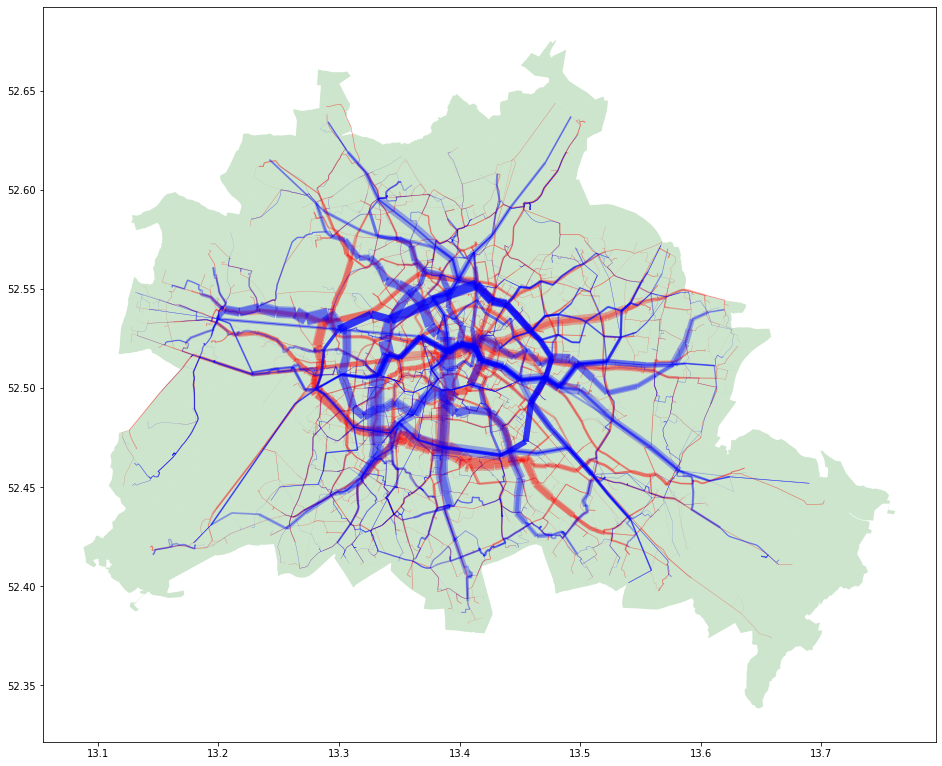

In [68]:
if show_plots:
    sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links, crs=sm.epsg)
    sm.road_links = gpd.GeoDataFrame(sm.road_links, crs=sm.epsg)
    scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / (35/2)

    fig, ax = plt.subplots(figsize = (10,10))
    sm.zones.plot(ax=ax, alpha=.2, color='green')
    sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))
    sm.loaded_links.plot(ax=ax, alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler))

    # sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    #     ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
    #         ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

## Read in validation data
To-Do:
- Maybe the addition of validation data can be moved to an earlier step in the process (Maybe directly after network creation)

,link_id,elem_nr,vnp,nnp,vst,bst,vricht,ebene,str_typ,strklasse1,strklasse,strklasse2,str_name,bezirk,stadtteil,dtvw_kfz,dtvw_lkw,geometry
5252,48490029_48490019,48490029_48490019.01,48490029.0,48490019.0,0.0,74.0,B,0.0,S,II,G,STRA,Hermannstraße,Neukölln,Neukölln,26900.0,710.0,"LINESTRING (13.43039 52.46910, 13.43050 52.468..."


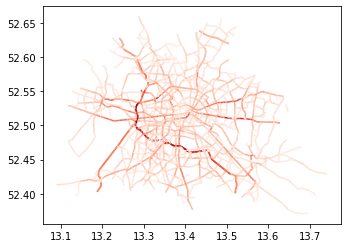

In [69]:
traffic_validation = gpd.read_file(input_path + "validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=4326, inplace=True)
traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)


In [70]:
sm.road_links.head()

,a,b,length,validation_load,validation_share,avspeed,time,walk_time,geometry,highway,maxspeed,validation_threshold,"(car_owner, car)","(pt_captive, car)","(all, car)"
index,,,,,,,,,,,,,,,
1,172539,34694265,237.653,10379.796248,1.000000,35.0,24.444309,171.11016,"LINESTRING (13.33550 52.56521, 13.33859 52.56428)",tertiary,50,True,NaN,NaN,0.0
2,172539,34694336,687.484,13820.164605,1.000000,35.0,70.712640,494.98848,"LINESTRING (13.33550 52.56521, 13.34515 52.56680)",secondary,50,True,NaN,NaN,0.0
3,172539,3977742457,391.153,19240.567732,1.000000,35.0,40.232880,281.63016,"LINESTRING (13.33550 52.56521, 13.33114 52.56289)",secondary,50,True,NaN,NaN,0.0
4,172545,271370539,17.179,12033.495869,0.881115,35.0,1.766983,12.36888,"LINESTRING (13.34661 52.56703, 13.34664 52.56688)",tertiary,50,False,NaN,NaN,0.0
5,172545,28345515,171.849,9612.436767,1.000000,35.0,17.675897,123.73128,"LINESTRING (13.34661 52.56703, 13.34681 52.56857)",tertiary,50,True,NaN,NaN,0.0


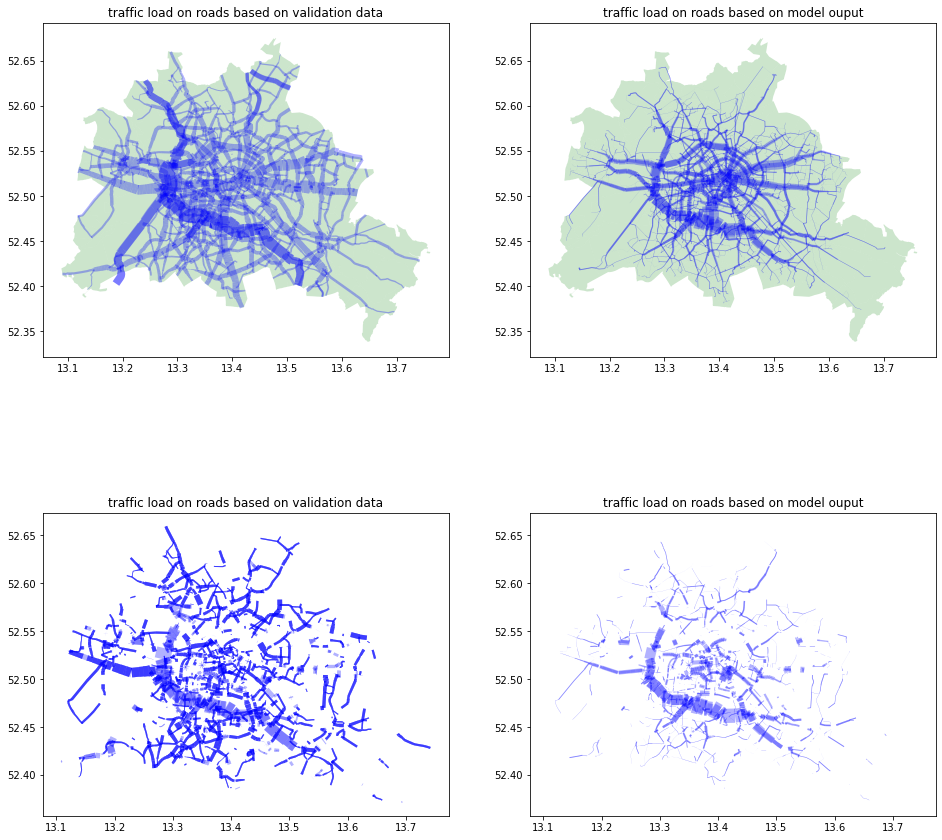

In [71]:
if show_plots:
    scaler_v = traffic_validation['dtvw_kfz'].max() / (35)


    fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (16,16), sharex='all', sharey='all')
    sm.zones.plot(ax=ax.flat[0], alpha=.2, color='green')
    sm.zones.plot(ax=ax.flat[1], alpha=.2, color='green')
    traffic_validation.plot(ax=ax.flat[0], alpha=.3, color="blue", linewidth=list(traffic_validation['dtvw_kfz']/(scaler)))
    sm.road_links.plot(ax=ax.flat[1], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')]/scaler))
    ratio=sm.road_links[('all', 'car')][sm.road_links['validation_threshold']].sum()/sm.road_links['validation_load'][sm.road_links['validation_threshold']].sum()
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[2], alpha=.3, color='blue', linewidth=list(sm.road_links['validation_load'][sm.road_links['validation_threshold']]/scaler))
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[3], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']]/(scaler)))
    ax.flat[0].set_title('traffic load on roads based on validation data')
    ax.flat[1].set_title('traffic load on roads based on model ouput')
    ax.flat[2].set_title('traffic load on roads based on validation data')
    ax.flat[3].set_title('traffic load on roads based on model ouput')


#### Validation data and sm.road_links

network: 46698334.44720787 validation: 249346530.4071401 ratio n/v: 0.187


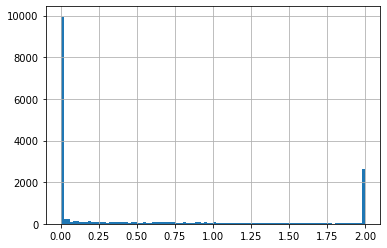

In [72]:
total_load_network = sum(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']])
total_load_validation = sum(sm.road_links['validation_load'][sm.road_links['validation_threshold']])
print('network:', total_load_network, 
    'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network/total_load_validation,3))

r_gdf = GeoDataFrame({
    'ratio': total_load_validation/total_load_network * sm.road_links[('all', 'car')][sm.road_links['validation_threshold']] / sm.road_links['validation_load'][sm.road_links['validation_threshold']]
    }, geometry=sm.road_links['geometry'][sm.road_links['validation_threshold']], crs=sm.epsg)

# ax0 = r_gdf['ratio'].hist(bins=100)
r_gdf['ratio_cut']=[x if x<2 else 2 for x in r_gdf['ratio']]
ax1 = r_gdf['ratio_cut'].hist(bins=100)


In [73]:

# what can be a validation parameter?
# maybe correlation of shares

load_network = sm.road_links[('all', 'car')][sm.road_links['validation_threshold']] #sum()
load_validation = sm.road_links['validation_load'][sm.road_links['validation_threshold']] #sum()

load_share_network = load_network/load_network.sum()
load_share_validation = load_validation/load_validation.sum()

corr = np.corrcoef(load_share_network, load_share_validation)[0,1]
print(corr)

0.45285776532734495


In [74]:
load_network.sum(), load_validation.sum(), load_network.sum()/ load_validation.sum()

(46698334.447208114, 249346530.40713876, 0.18728287243844138)

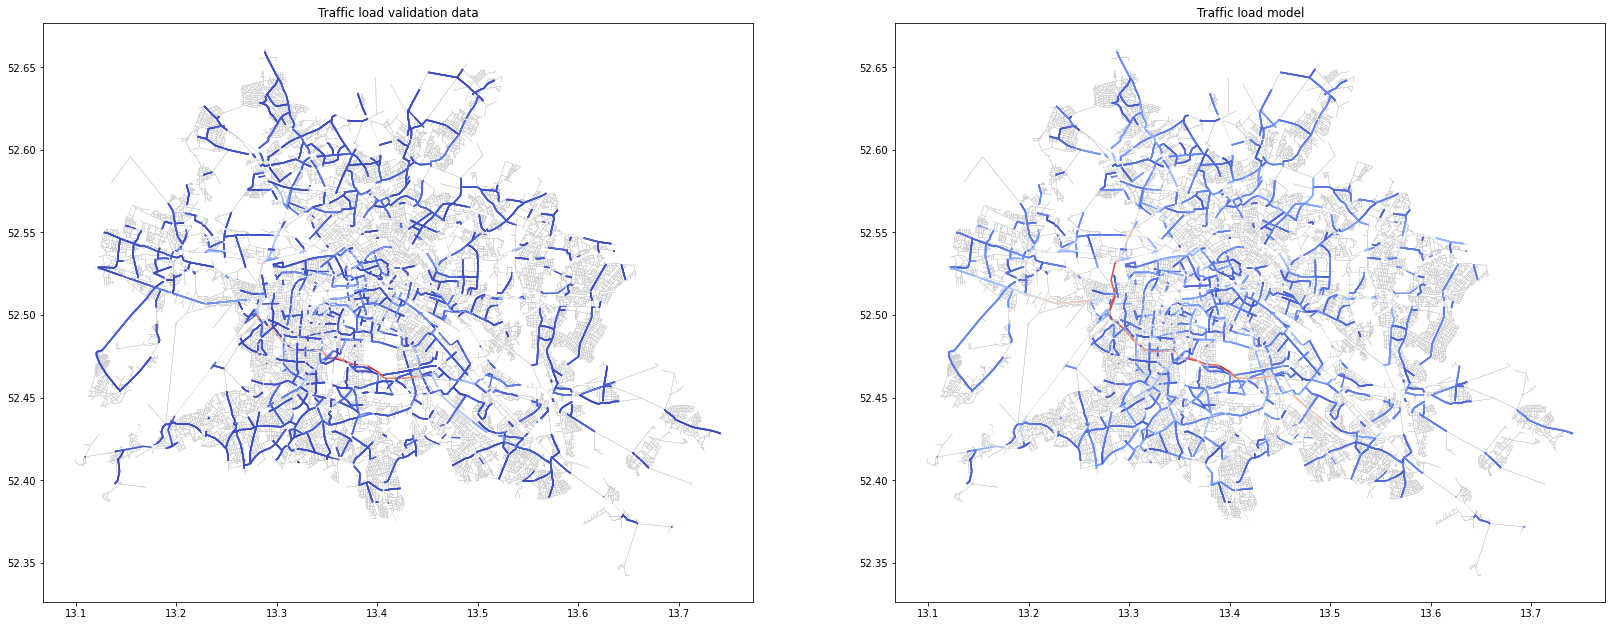

In [75]:
if show_plots:
    fig, ax = plt.subplots(ncols=2, figsize = (28,16), sharex='all', sharey='all')
    sm.road_links.plot(ax=ax.flat[0], color="#cccccc", linewidth=0.25)
    sm.road_links.plot(ax=ax.flat[1], color="#cccccc", linewidth=0.25)
    col0 = np.array([x for x in sm.road_links[('all', 'car')][(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)]])
    col1 = np.array([x for x in sm.road_links['validation_load'][(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)]])
    sm.road_links[(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)].plot(ax=ax.flat[0], column=col0, cmap='coolwarm')#, legend=True
    sm.road_links[(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)].plot(ax=ax.flat[1], column=col1, cmap='coolwarm')#, legend=True
    ax.flat[0].set_title("Traffic load validation data")
    ax.flat[1].set_title("Traffic load model")


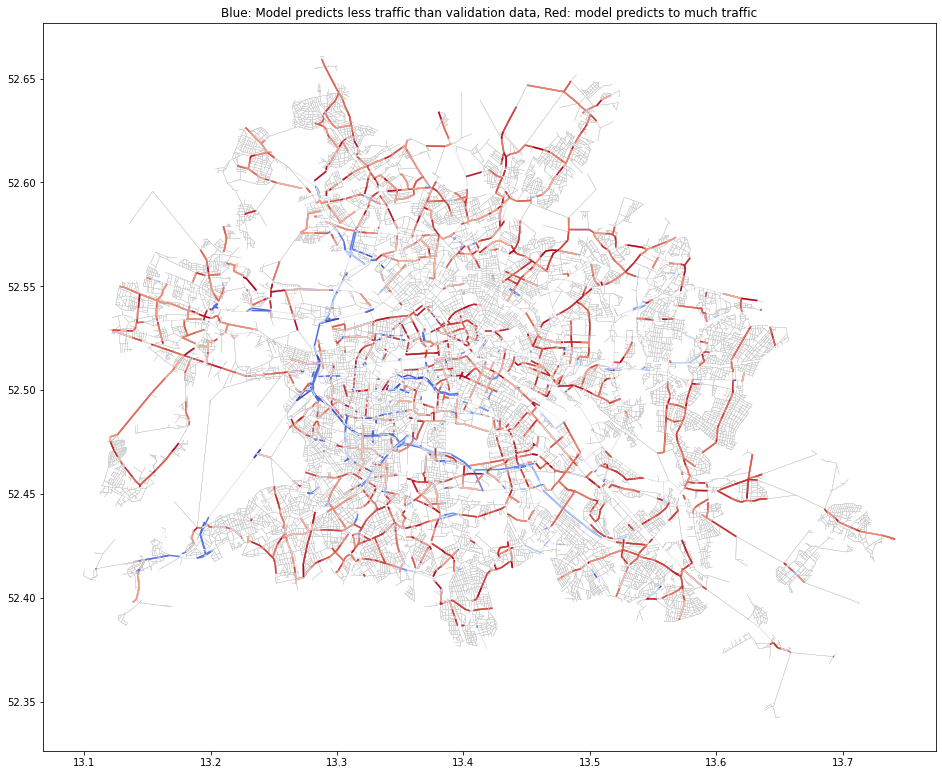

In [76]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    sm.road_links.plot(ax=ax, color="#cccccc", linewidth=0.25)
    r_gdf.plot(ax=ax, cmap='coolwarm', legend=True)
    ax.set_title("Blue: Model predicts less traffic than validation data, Red: model predicts to much traffic")

#### Validation data and sm.loaded_links

In [77]:
# total_load_network_l = sum(sm.loaded_links['load'][sm.loaded_links['validation_threshold']])
# total_load_validation = sum(sm.loaded_links['validation_load'][sm.loaded_links['validation_threshold']])
# print('network:', total_load_network_l, 
#     'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network_l/total_load_validation,3))

## Model Results

In [78]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [79]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [80]:
od_sum.sample(3)

segment                          car_owner                      \
sum                                 volume     price      time   
origin        destination   mode                                 
zone_01033201 zone_12214528 car   3.842069  1.456512  0.538131   
zone_08040933 zone_03020209 car   5.406926  2.354073  0.639520   
zone_10020622 zone_07050506 car   1.303957  2.658554  0.719592   

segment                                                                 \
sum                              in_vehicle_time     length ntransfers   
origin        destination   mode                                         
zone_01033201 zone_12214528 car              0.0  12.137598        0.0   
zone_08040933 zone_03020209 car              0.0  19.617276        0.0   
zone_10020622 zone_07050506 car              0.0  22.154614        0.0   

segment                             pt_captive                              \
sum                                     volume         price          time   
origin        destination   mode                                             
zone_01033201 zone_12214528 car   1.249734e-41  3.159489e-42  1.167323e-42   
zone_08040933 zone_03020209 car   9.041735e-42  2.625093e-42  7.131466e-43   
zone_10020622 zone_07050506 car   9.943060e-43  1.351345e-42  3.657692e-43   

segment                                           ...                 root  \
sum                              in_vehicle_time  ... ntransfers    volume   
origin        destination   mode                  ...                        
zone_01033201 zone_12214528 car              0.0  ...        0.0  3.842069   
zone_08040933 zone_03020209 car              0.0  ...        0.0  5.406926   
zone_10020622 zone_07050506 car              0.0  ...        0.0  1.303957   

segment                                                               \
sum                                  price      time in_vehicle_time   
origin        destination   mode                                       
zone_01033201 zone_12214528 car   1.456512  0.538131             0.0   
zone_08040933 zone_03020209 car   2.354073  0.639520             0.0   
zone_10020622 zone_07050506 car   2.658554  0.719592             0.0   

segment                                                  car_owner  \
sum                                  length ntransfers         pkm   
origin        destination   mode                                     
zone_01033201 zone_12214528 car   12.137598        0.0   46.633495   
zone_08040933 zone_03020209 car   19.617276        0.0  106.069168   
zone_10020622 zone_07050506 car   22.154614        0.0   28.888658   

segment                             pt_captive        root  
sum                                        pkm         pkm  
origin        destination   mode                            
zone_01033201 zone_12214528 car   3.290434e-82   46.633495  
zone_08040933 zone_03020209 car   1.977950e-82  106.069168  
zone_10020622 zone_07050506 car   1.119708e-83   28.888658  

[3 rows x 21 columns]

In [87]:
sm.pt_los

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,footpath_length,in_vehicle_length,length,price,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)",pivot
0,zone_01011101,zone_01011101,0.000000,[zone_01011101],best_path,False,[],[],[],[],...,0.0,0.000,0.000000,3.75,0,-3.750000,-3.750000,0.022977,1.0,1.0
1,zone_01011101,zone_01011102,792.010207,"[zone_01011101, n_496, zone_01011102]",best_path,False,[],[],[n_496],[],...,0.0,0.000,1125.398927,3.75,0,-4.185606,-4.185606,0.022699,1.0,1.0
2,zone_01011101,zone_01011103,734.167399,"[zone_01011101, n_496, zone_01011103]",best_path,False,[],[],[n_496],[],...,0.0,0.000,948.876493,3.75,0,-4.153792,-4.153792,0.021595,1.0,1.0
3,zone_01011101,zone_01011104,1156.649404,"[zone_01011101, n_496, link_10229, n_195, zone...",best_path,False,[n_496],[n_195],"[n_496, n_195]",[link_10229],...,0.0,1256.790,2212.763876,3.75,0,-4.386157,-4.386157,0.018853,1.0,1.0
4,zone_01011101,zone_01011105,869.899147,"[zone_01011101, n_496, link_10229, n_195, zone...",best_path,False,[n_496],[n_195],"[n_496, n_195]",[link_10229],...,0.0,1256.790,1725.689610,3.75,0,-4.228445,-4.228445,0.021230,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200699,zone_12304314,zone_12302110,1752.758637,"[zone_12304314, n_471, link_6387, link_6389, l...",best_path,False,[n_471],[n_190],"[n_471, n_190]","[link_6387, link_6389, link_6392, link_6394, l...",...,0.0,8748.299,9280.186155,3.75,0,-4.714017,-4.714017,0.025525,1.0,1.0
200700,zone_12304314,zone_12302211,1565.505362,"[zone_12304314, n_471, link_6427, link_6429, l...",best_path,False,[n_471],[n_685],"[n_471, n_685]","[link_6427, link_6429, link_6432, link_6434]",...,0.0,3258.528,4242.811398,3.75,0,-4.611028,-4.611028,0.019714,1.0,1.0
200701,zone_12304314,zone_12302212,1335.686161,"[zone_12304314, n_471, link_6427, link_6429, l...",best_path,False,[n_471],[n_685],"[n_471, n_685]","[link_6427, link_6429, link_6432, link_6434]",...,0.0,3258.528,3691.632293,3.75,0,-4.484627,-4.484627,0.019861,1.0,1.0
200702,zone_12304314,zone_12304313,1021.410156,"[zone_12304314, n_761, zone_12304313]",best_path,False,[],[],[n_761],[],...,0.0,0.000,1825.297804,3.75,0,-4.311776,-4.311776,0.022793,1.0,1.0


array([<AxesSubplot:ylabel='(car_owner, volume)'>,
       <AxesSubplot:ylabel='(pt_captive, volume)'>], dtype=object)

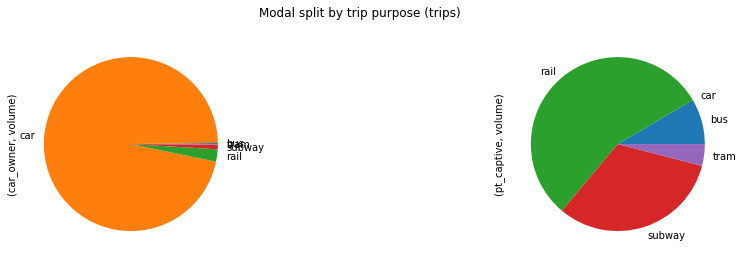

In [81]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='(car_owner, pkm)'>,
       <AxesSubplot:ylabel='(pt_captive, pkm)'>], dtype=object)

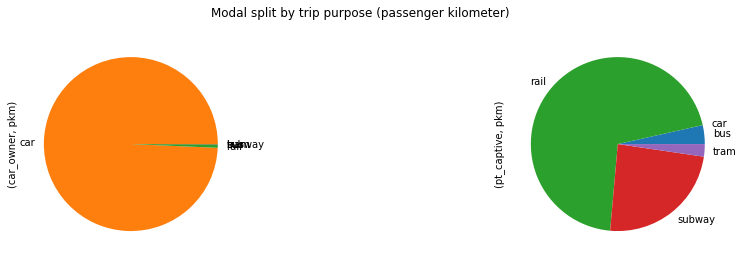

In [82]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

## Save model

In [83]:
# # Save the od_sum as Excel
# if not os.path.exists('../../outputs/'):
#     os.makedirs('../../outputs/')
# with pd.ExcelWriter('../../outputs/od_summary.xlsx') as writer:  
#     od_sum.to_excel(writer, sheet_name='od_sum')

In [84]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [85]:
sm.to_json(model_path + 'four_steps')

to_hdf(overwriting):  60%|██████    | 27/45 [01:49<00:29,  1.66s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|██████████| 45/45 [02:48<00:00,  3.74s/it]

could not save attribute: parameters
